<a href="https://colab.research.google.com/github/Thanisthani/Region_detection_unmask_vgg16/blob/main/V2_0_Region_detection_keras_VGG16_unmask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import lib

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

Mount g drive

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Add dataset path

In [3]:
import pathlib
data_dir='/content/gdrive/MyDrive/Region_detection/data/images'
data_dir = pathlib.Path(data_dir).with_suffix('')

Pre process the data

In [4]:

# Define the image size and batch size
img_size = (224, 224)
batch_size = 32

# Load the training and validation datasets
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.


Find clas names

In [5]:
class_names = train_dataset.class_names
print(class_names)

['EastAsian', 'SouthAsian']


Config dataset for performance

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Data agumentation

In [7]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visulaize data agumentation

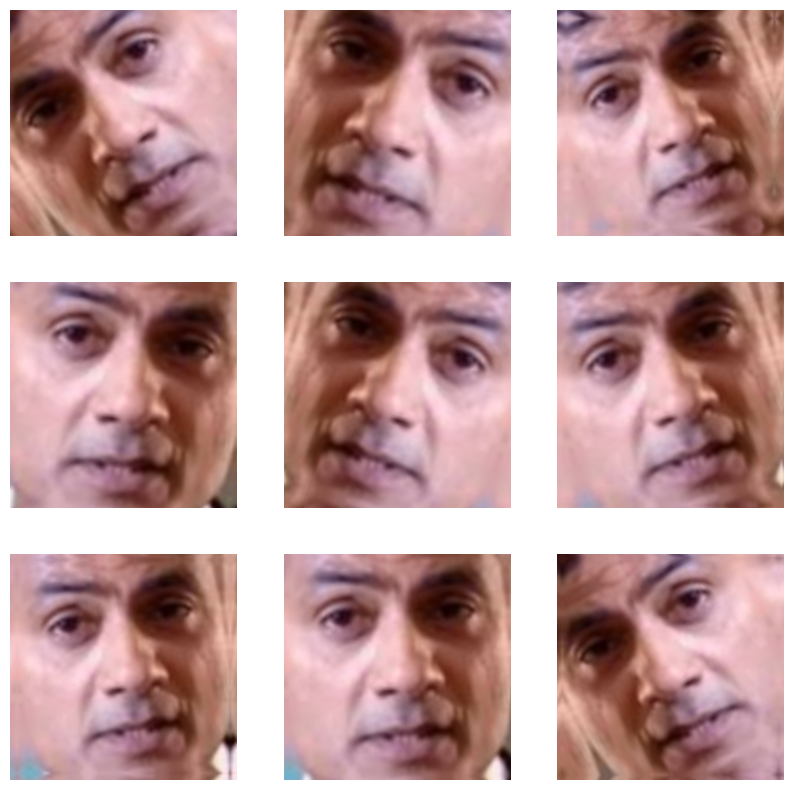

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout

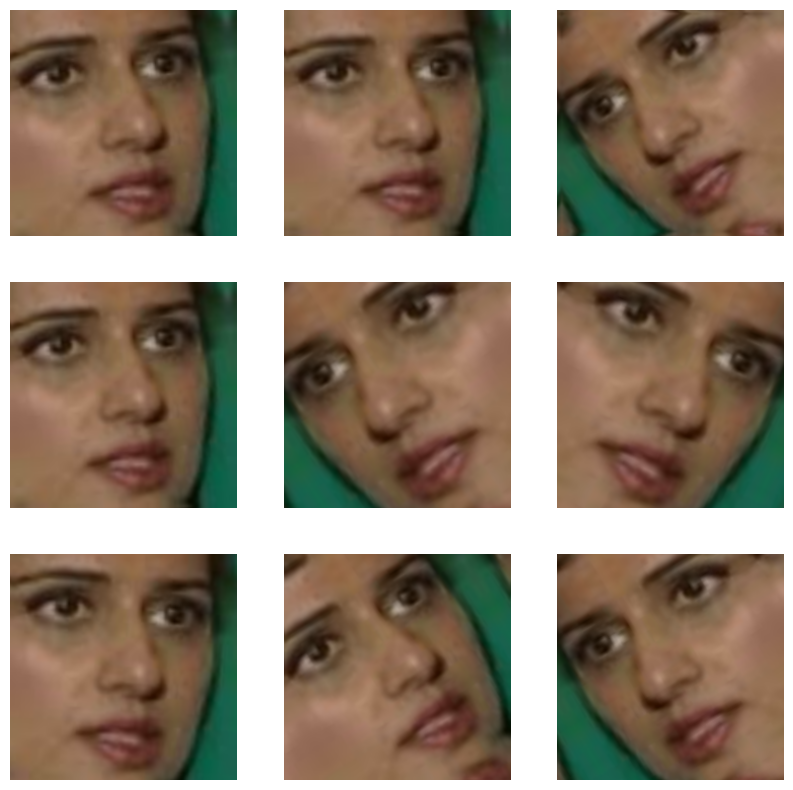

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Load pre trained model

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


Freeze convolutional base

In [8]:

for layer in base_model.layers:
    layer.trainable = False

Compile model

In [9]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.legacy.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train model

In [10]:
epochs = 10
# history = model.fit(train_dataset,
#                     epochs=epochs,
#                     validation_data=validation_dataset)
history = model.fit(train_dataset, validation_data = validation_dataset, epochs = epochs)

Epoch 1/10
60/60 [==============================] - 245s 3s/step - loss: 1.4309 - acc: 0.9354 - val_loss: 0.0761 - val_acc: 0.9896
Epoch 2/10
60/60 [==============================] - 10s 168ms/step - loss: 0.1798 - acc: 0.9870 - val_loss: 0.0476 - val_acc: 0.9917
Epoch 3/10
60/60 [==============================] - 11s 170ms/step - loss: 0.0892 - acc: 0.9911 - val_loss: 0.0876 - val_acc: 0.9896
Epoch 4/10
60/60 [==============================] - 11s 165ms/step - loss: 0.0510 - acc: 0.9937 - val_loss: 0.0345 - val_acc: 0.9958
Epoch 5/10
60/60 [==============================] - 11s 173ms/step - loss: 0.0799 - acc: 0.9901 - val_loss: 0.0579 - val_acc: 0.9937
Epoch 6/10
60/60 [==============================] - 11s 172ms/step - loss: 0.0241 - acc: 0.9979 - val_loss: 0.1124 - val_acc: 0.9917
Epoch 7/10
60/60 [==============================] - 11s 173ms/step - loss: 0.0224 - acc: 0.9969 - val_loss: 0.0929 - val_acc: 0.9937
Epoch 8/10
60/60 [==============================] - 11s 174ms/step - lo

Evaluation

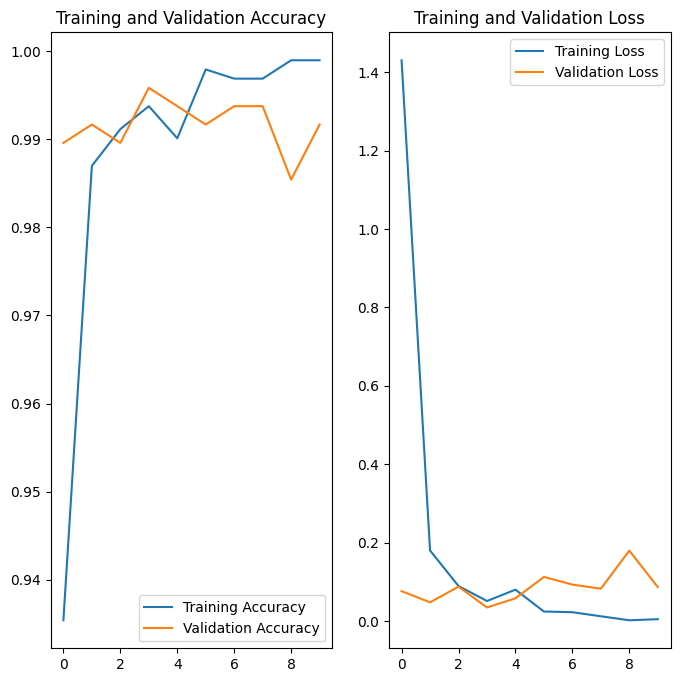

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 2)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing model

In [18]:
def predict_image(model, img_path):
    # Preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Make predictions
    predictions = model.predict(img_array)

    print(predictions[0] )
    # Decode the predictions to the original labels
    predicted_label = "East Asian" if predictions[0] > 0 else "South asian"

    return predicted_label

In [19]:
import cv2
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    # Load the image file, resizing it to the input size of our model
    img = image.load_img(img_path, target_size=img_size)

    # Convert the image to array
    img_array = image.img_to_array(img)

    # Normalize the image pixels
    img_array /= 255.0

    # Expand dimensions to fit the batch size
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [32]:
img_path = "/content/gdrive/MyDrive/Region_detection/data/test_image/image8.jpg"  # Replace with the path of your image
predicted_label = predict_image(model, img_path)

print(f"The model predicts that the image is a {predicted_label}")

1/1 [==============================] - 0s 164ms/step
[0.9999312]
The model predicts that the image is a East Asian


Find accuracy

In [12]:
# Evaluate on the validation set
evaluation = model.evaluate(validation_dataset)

# Print the evaluation results
print(f"Evaluation Results: {evaluation}")
print(f"Accuracy: {evaluation[1]*100:.2f}%")
# print(f"Precision: {evaluation[2]*100:.2f}%")
# print(f"Recall: {evaluation[3]*100:.2f}%")

15/15 [==============================] - 2s 125ms/step - loss: 0.0866 - acc: 0.9917
Evaluation Results: [0.0866115465760231, 0.9916666746139526]
Accuracy: 99.17%
